In [25]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
#import corr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

XGBOOST_TREE_METHOD = "hist"

In [26]:
df = pd.read_csv('datasets/all_seasons.csv')
expanded_allstars_df = pd.read_csv('datasets/expanded_allstars_fixed.csv')
df.head(5)


,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,0,Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,2,...,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97
1,1,Gaylon Nickerson,WAS,28.0,190.50,86.182480,Northwestern Oklahoma,USA,1994,2,...,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97
2,2,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1,...,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97
3,3,George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1,...,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97
4,4,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1,...,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97


In [27]:
# Criar a coluna 'all_star' com base nos jogadores e temporadas do arquivo expandido do All-Star
def add_all_star_column(all_seasons_df, allstars_df):
    all_seasons_df['all_star'] = all_seasons_df.apply(
        lambda row: 1 if ((row['player_name'] in allstars_df['player_name'].values) and
                          (row['season'] in allstars_df[allstars_df['player_name'] == row['player_name']]['expanded_seasons'].values)) else 0,
        axis=1
    )
    return all_seasons_df

# Adicionar a coluna all_star
all_seasons = add_all_star_column(df, expanded_allstars_df)
all_seasons.drop(columns=["Unnamed: 0"], inplace=True)

# Salvar o arquivo atualizado
all_seasons.to_csv('all_seasons_with_all_star.csv', index=False)

# na verdade, vou usar o arquivo com popularidade
all_seasons = pd.read_csv('datasets/all_seasons_with_all_star_with_popularity.csv')

## Pré-Processamento

In [28]:
all_seasons.isnull().sum()

player_name             0
team_abbreviation       0
age                     0
player_height           0
player_weight           0
college              1854
country                 0
draft_year              0
draft_round             0
draft_number            0
gp                      0
pts                     0
reb                     0
ast                     0
net_rating              0
oreb_pct                0
dreb_pct                0
usg_pct                 0
ts_pct                  0
ast_pct                 0
season                  0
all_star                0
popularity              0
dtype: int64

In [29]:
# Substituindo as linhas nulas por "Unknown"
all_seasons['college'].fillna('Unknown', inplace=True)
all_seasons.isnull().sum()

/tmp/ipykernel_7388/3852955707.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_seasons['college'].fillna('Unknown', inplace=True)


player_name          0
team_abbreviation    0
age                  0
player_height        0
player_weight        0
college              0
country              0
draft_year           0
draft_round          0
draft_number         0
gp                   0
pts                  0
reb                  0
ast                  0
net_rating           0
oreb_pct             0
dreb_pct             0
usg_pct              0
ts_pct               0
ast_pct              0
season               0
all_star             0
popularity           0
dtype: int64

In [30]:
# Selecionando colunas numéricas
colunas_numericas = all_seasons.select_dtypes(include=['float64', 'int64']).columns

#Removendo a coluna all_star das númericas porque só assume dois valores (0 ou 1)
colunas_numericas = colunas_numericas.drop('all_star')

# removendo a coluna popularity porque só assume 0 ou 1
colunas_numericas = colunas_numericas.drop('popularity')

print(colunas_numericas)

Index(['age', 'player_height', 'player_weight', 'gp', 'pts', 'reb', 'ast',
       'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct'],
      dtype='object')


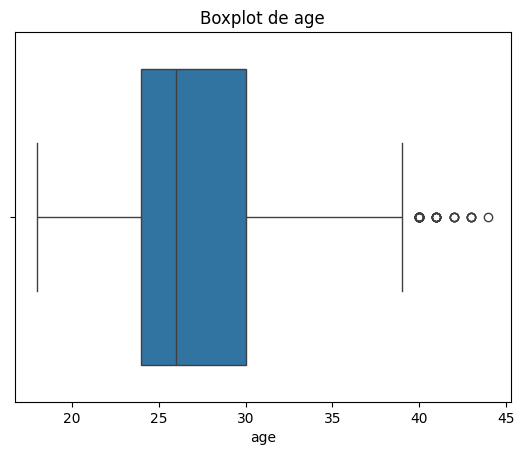

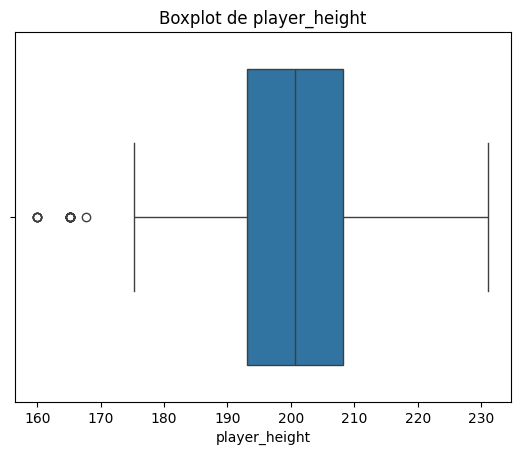

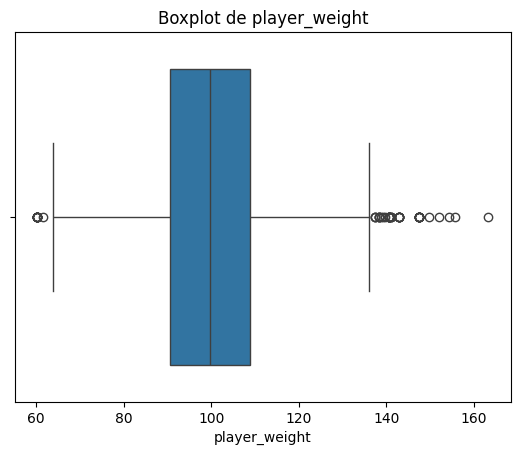

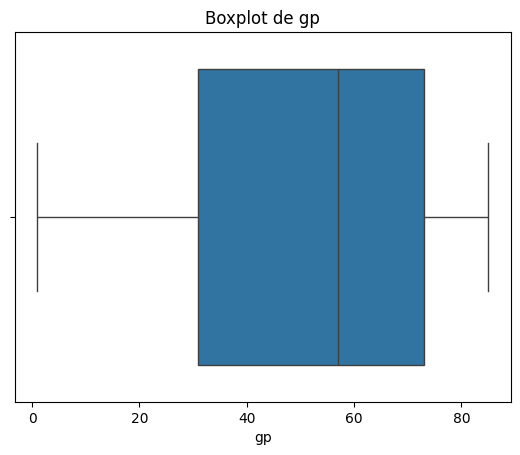

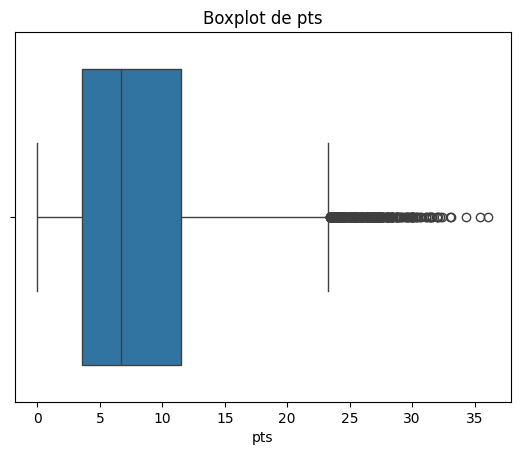

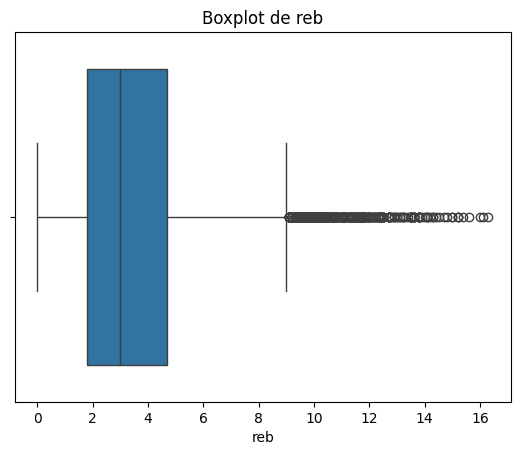

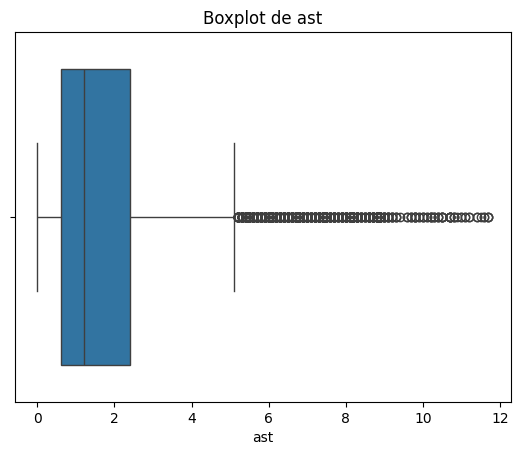

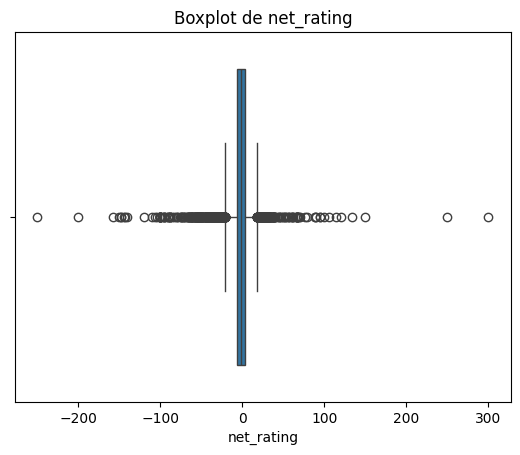

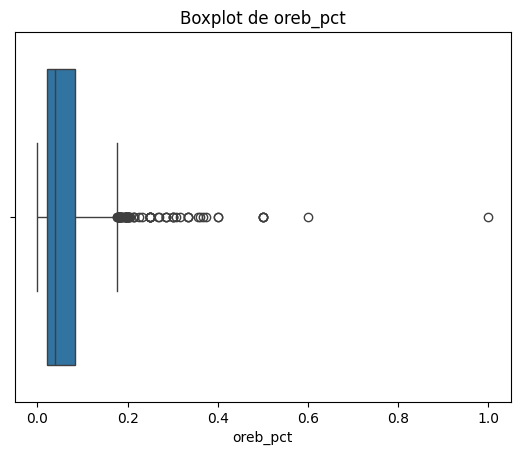

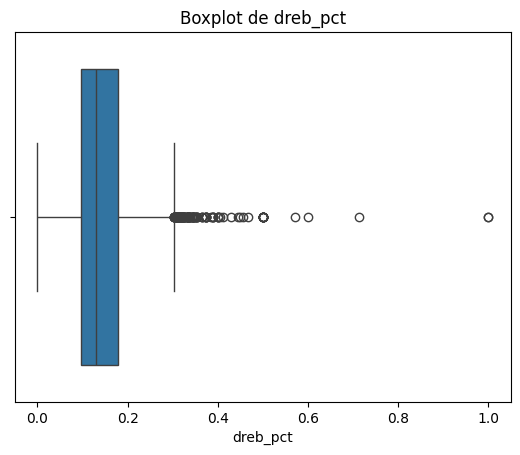

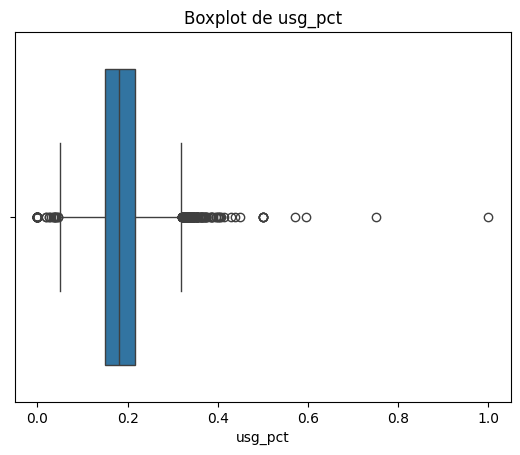

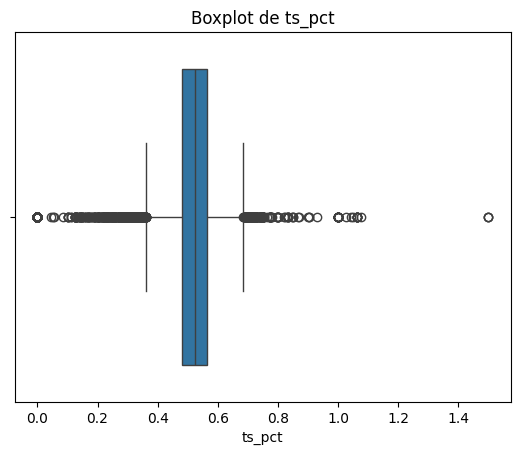

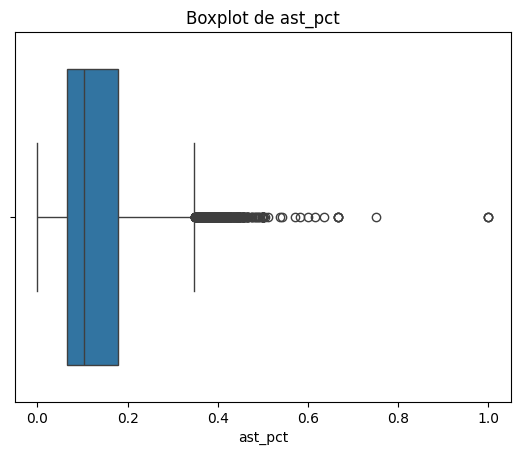

In [31]:
#Boxplot para visualizar outliers
for coluna in colunas_numericas:
    plt.figure()
    sns.boxplot(x=all_seasons[coluna])
    plt.title(f'Boxplot de {coluna}')
    plt.show()

In [32]:
# Loop para detectar e remover os outliers
for coluna in colunas_numericas:
    # Calcular Q1 (25º percentil) e Q3 (75º percentil)
    Q1 = all_seasons[coluna].quantile(0.25)
    Q3 = all_seasons[coluna].quantile(0.75)
    IQR = Q3 - Q1  # Intervalo interquartil

    # Limites para detectar outliers extremos
    limite_inferior = Q1 - 3.0 * IQR
    limite_superior = Q3 + 3.0 * IQR

    # Substituir outliers extremos pela média de sua ocorrência
    media_coluna = all_seasons[coluna].mean()
    all_seasons[coluna] = all_seasons[coluna].apply(lambda x: media_coluna if (x < limite_inferior or x > limite_superior) else x)

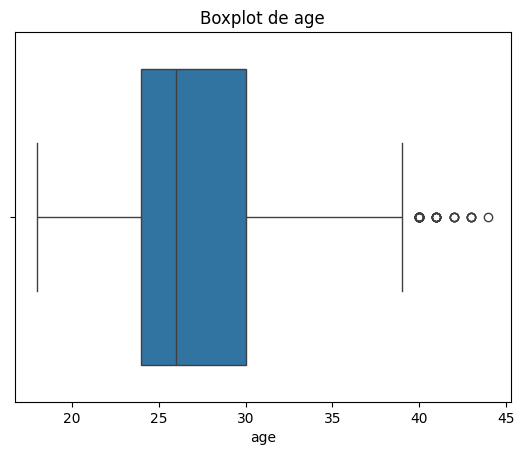

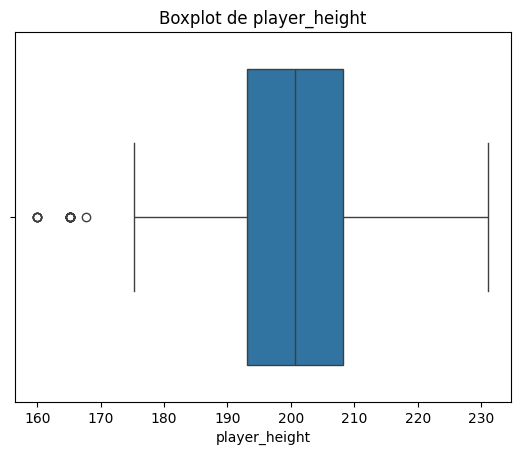

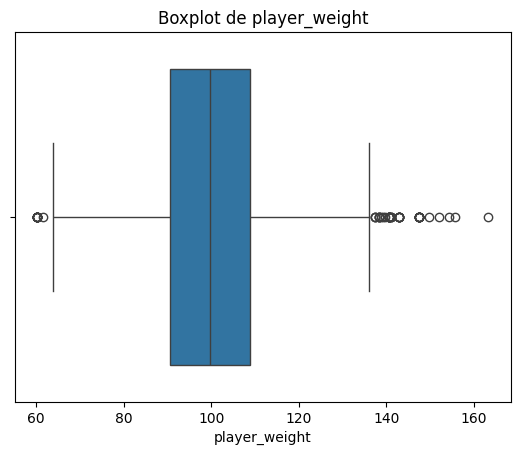

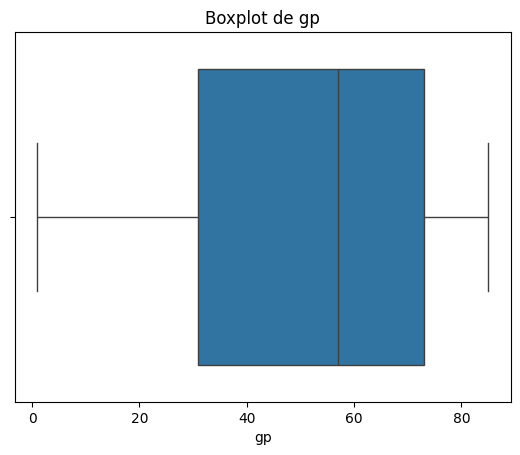

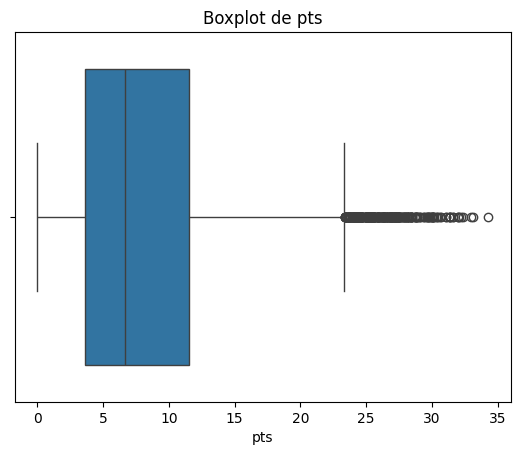

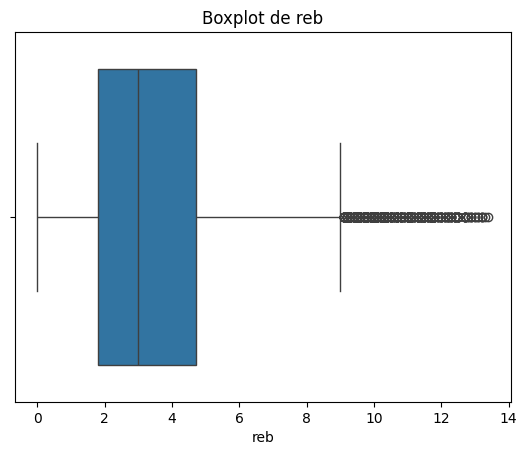

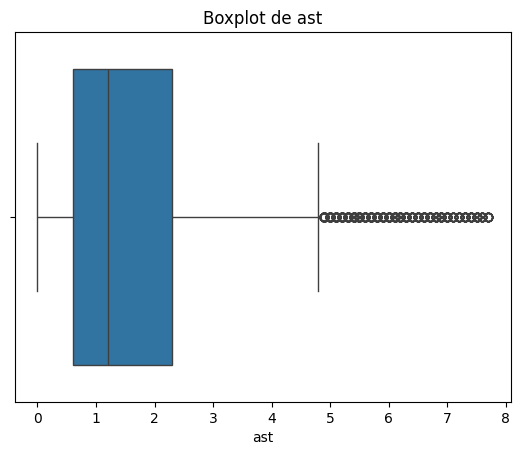

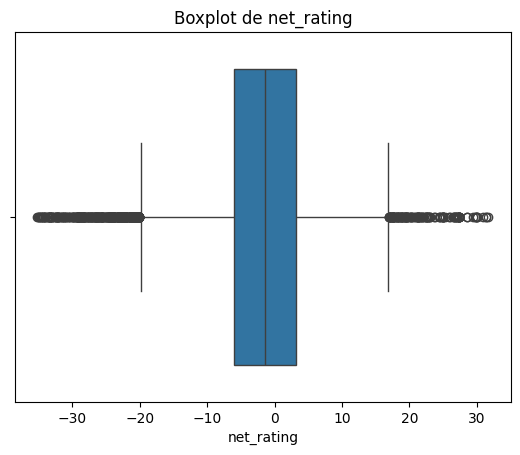

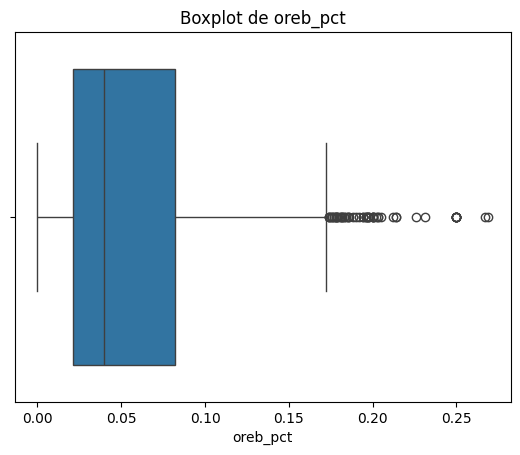

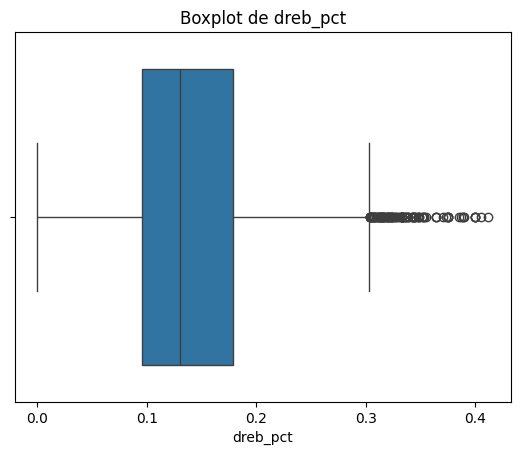

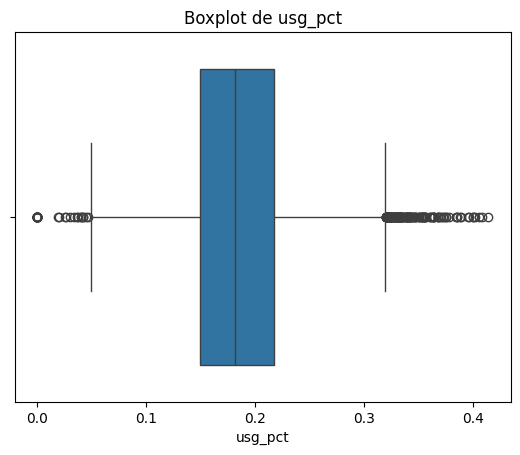

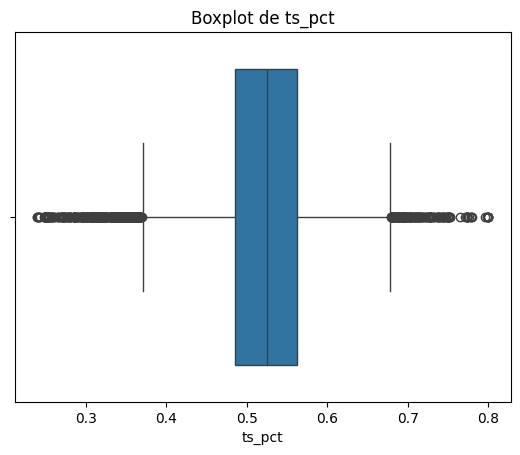

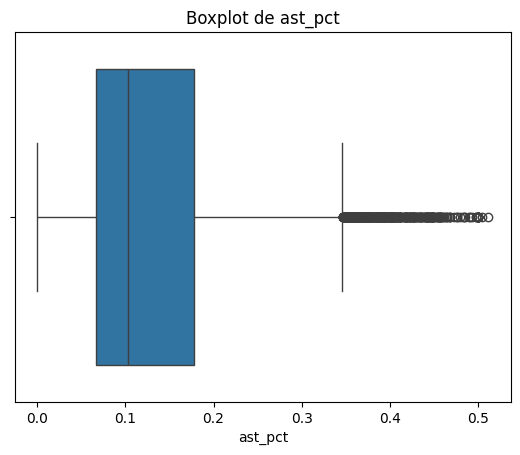

In [33]:
#Exibindo Boxplot após remover outliers extremos
for coluna in colunas_numericas:
    plt.figure()
    sns.boxplot(x=all_seasons[coluna])
    plt.title(f'Boxplot de {coluna}')
    plt.show()

## Iniciando a Análise Exploratória dos Dados

In [34]:
to_drop_columns = ["draft_number", "player_name", "team_abbreviation", "college", "season", "country", "draft_round", "draft_year"]

data = all_seasons.drop(columns=to_drop_columns)
data.head()

,age,player_height,player_weight,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,all_star,popularity
0,22.0,193.04,94.800728,64,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,0,0
1,28.0,190.50,86.182480,4,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,0,0
2,26.0,203.20,103.418976,41,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,0,0
3,30.0,203.20,102.058200,64,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,0,0
4,23.0,213.36,119.748288,52,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,0,0


In [35]:
all_seasons.shape

(12844, 23)

In [36]:
all_seasons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12844 entries, 0 to 12843
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player_name        12844 non-null  object 
 1   team_abbreviation  12844 non-null  object 
 2   age                12844 non-null  float64
 3   player_height      12844 non-null  float64
 4   player_weight      12844 non-null  float64
 5   college            12844 non-null  object 
 6   country            12844 non-null  object 
 7   draft_year         12844 non-null  object 
 8   draft_round        12844 non-null  object 
 9   draft_number       12844 non-null  object 
 10  gp                 12844 non-null  int64  
 11  pts                12844 non-null  float64
 12  reb                12844 non-null  float64
 13  ast                12844 non-null  float64
 14  net_rating         12844 non-null  float64
 15  oreb_pct           12844 non-null  float64
 16  dreb_pct           128

In [37]:
print(all_seasons.describe())

                age  player_height  player_weight            gp           pts  \
count  12844.000000   12844.000000   12844.000000  12844.000000  12844.000000   
mean      27.045313     200.555097     100.263279     51.154158      8.208294   
std        4.339211       9.111090      12.426628     25.084904      6.006749   
min       18.000000     160.020000      60.327736      1.000000      0.000000   
25%       24.000000     193.040000      90.718400     31.000000      3.600000   
50%       26.000000     200.660000      99.790240     57.000000      6.700000   
75%       30.000000     208.280000     108.862080     73.000000     11.500000   
max       44.000000     231.140000     163.293120     85.000000     34.300000   

                reb           ast    net_rating      oreb_pct      dreb_pct  \
count  12844.000000  12844.000000  12844.000000  12844.000000  12844.000000   
mean       3.524284      1.715135     -1.744363      0.053450      0.139970   
std        2.402122      1.555550

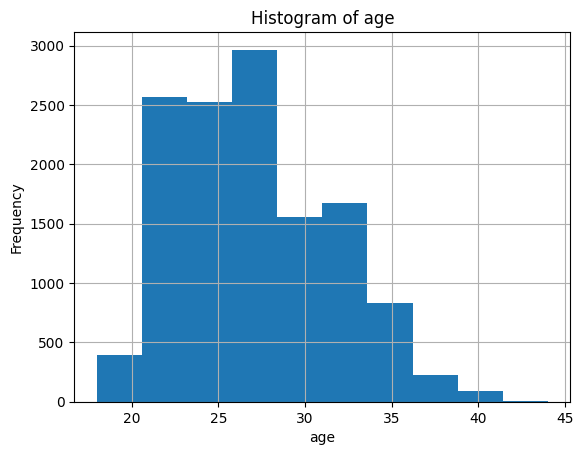

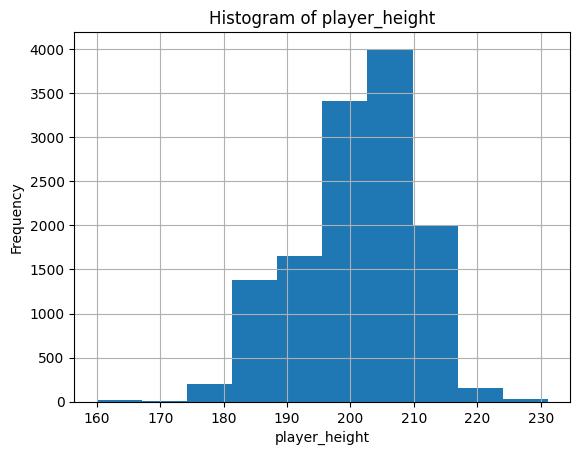

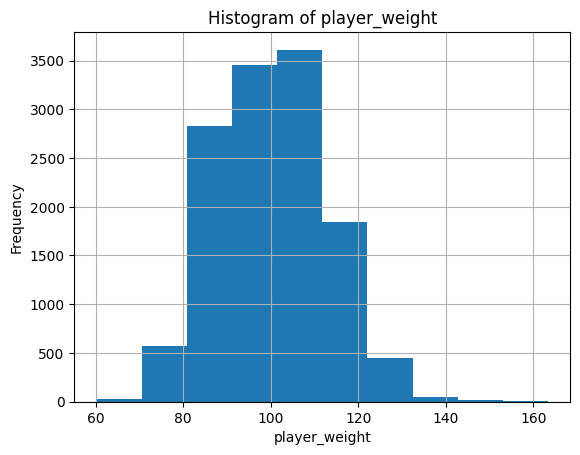

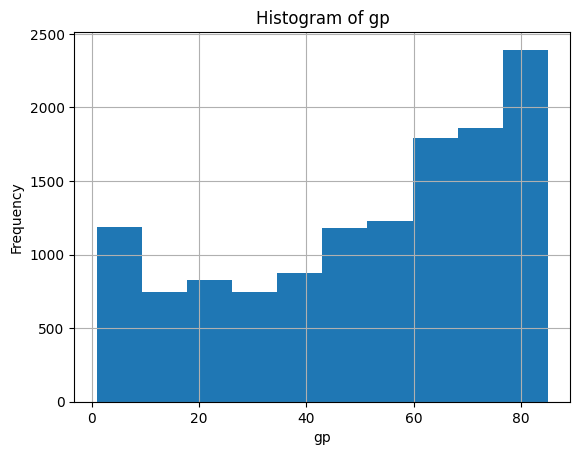

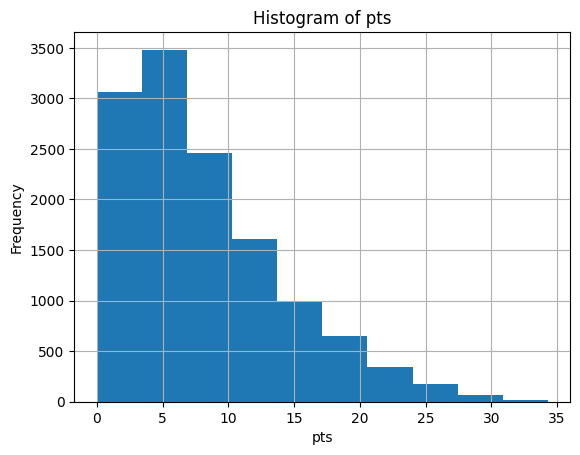

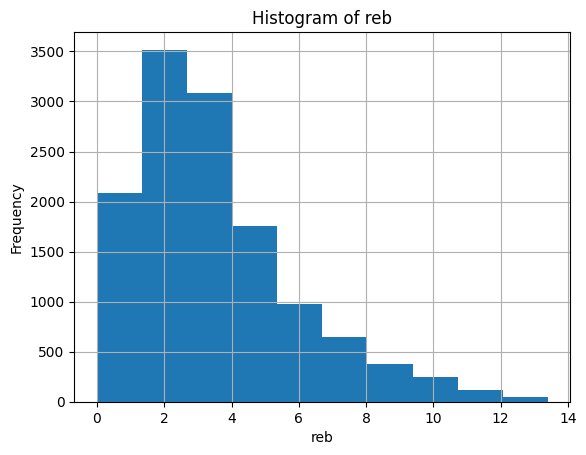

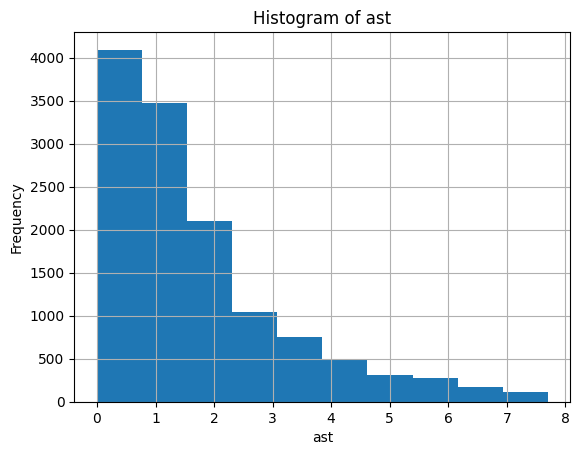

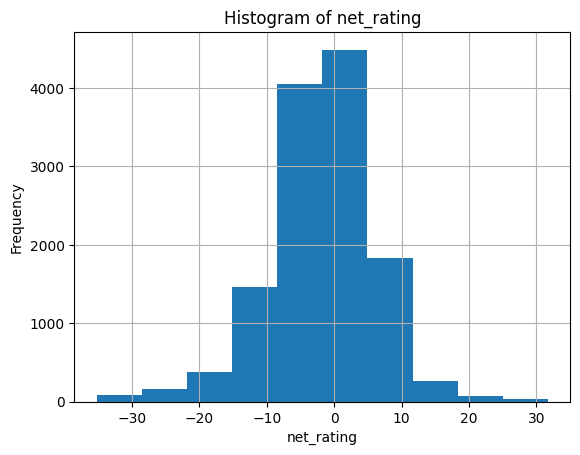

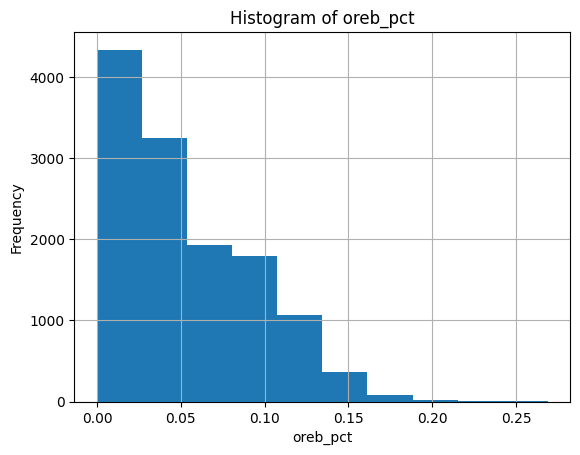

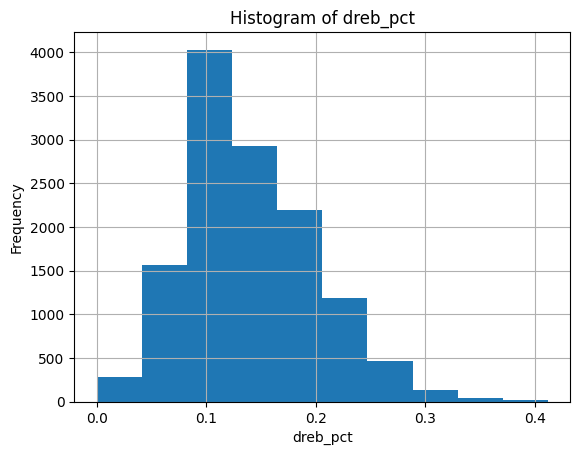

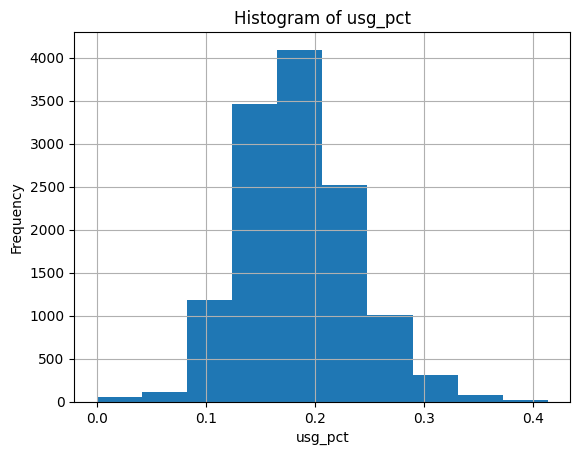

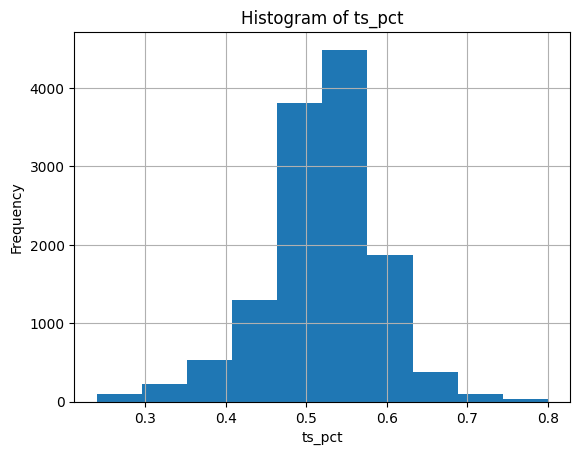

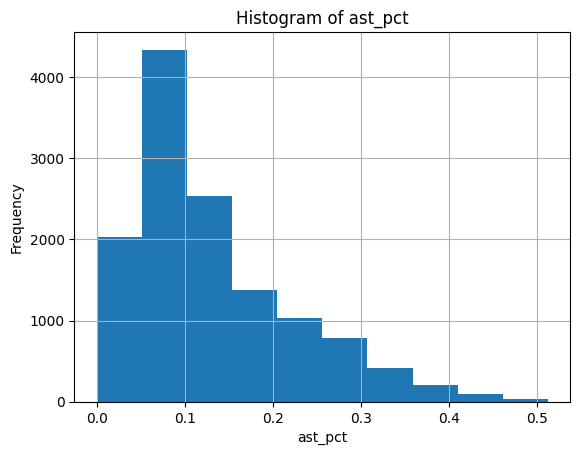

In [38]:
#Distribuição das Variáveis

numeric_cols = ['age', 'player_height', 'player_weight', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct']
for col in numeric_cols:
    plt.figure()
    all_seasons[col].hist()
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

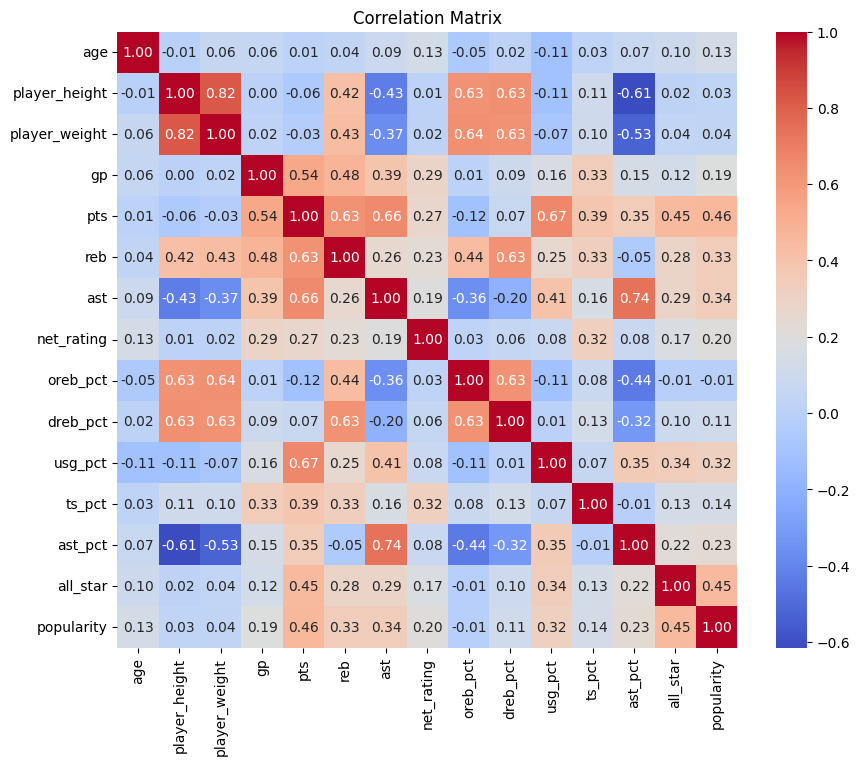

In [39]:
# Excluindo as colunas não numéricas
all_seasons_numeric = data
correlation_matrix = all_seasons_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

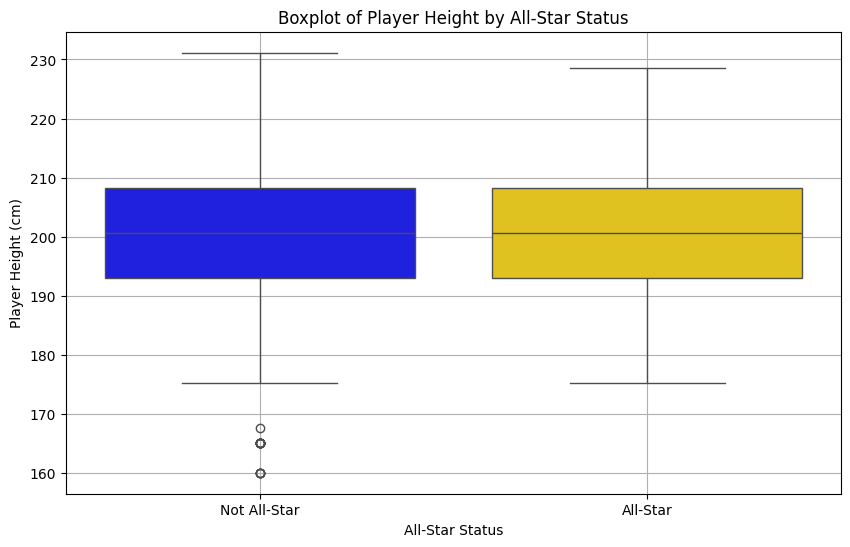

In [40]:
# Gerar um boxplot para a altura dos jogadores
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x='all_star', y='player_height', hue='all_star', data=all_seasons, palette={0: 'blue', 1: 'gold'}, dodge=False)
plt.title('Boxplot of Player Height by All-Star Status')
plt.xlabel('All-Star Status')
plt.ylabel('Player Height (cm)')
plt.xticks([0, 1], ['Not All-Star', 'All-Star'])

# Como 'hue' e 'x' são os mesmos, podemos esconder a legenda redundante
plt.legend([],[], frameon=False)

plt.grid(True)
plt.show()

**Observações:**

As variáveis de altura e peso possuem a maior correlação, o que faz sentido, dado que os jogadores com as maiores alturas costumam ser, de fato, os mais pesados.

As variáveis de assistência e porcentagem de assistências também possuim um valor de correlação considerável, mas ambas serão utilizadas dado que suas finalidades são distintas: a coluna "ast_pct" mede a porcentagem de assistências do jogador em relação ao total do time na temporada, enquanto "ast" é simplesmente a média da quantidade de assistências por partida do jogador.

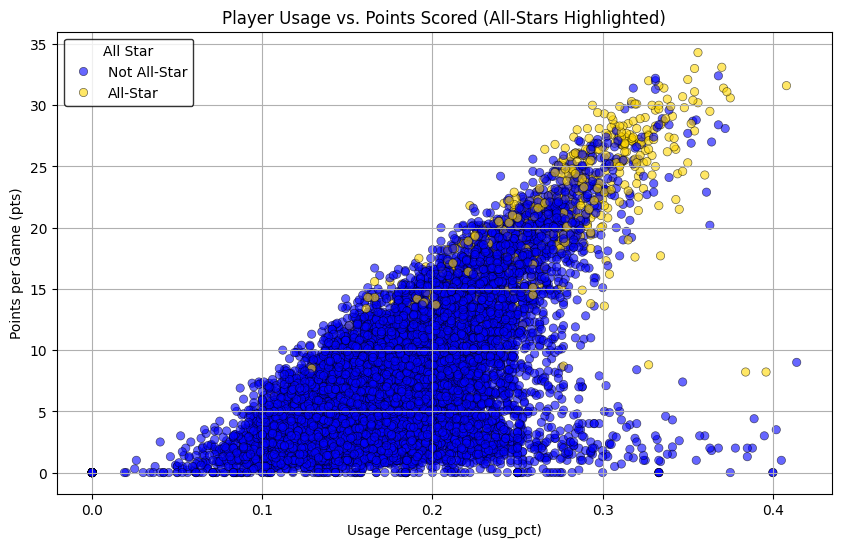

In [41]:
#gráfico de dispersão que mostre a pontuação média (pts) versus a porcentagem de uso (usg_pct) para jogadores,
#destacando aqueles que foram All-Stars em comparação com aqueles que não foram.
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='usg_pct', y='pts', hue='all_star', palette={0: 'blue', 1: 'gold'}, data=all_seasons, alpha=0.6, edgecolor='black')

# Ajustes na legenda para corresponder às cores corretas
handles, labels = scatter.get_legend_handles_labels()
scatter.legend(handles, ['Not All-Star', 'All-Star'], title='All Star', loc='upper left', frameon=True, facecolor='white', edgecolor='black')

plt.title('Player Usage vs. Points Scored (All-Stars Highlighted)')
plt.xlabel('Usage Percentage (usg_pct)')
plt.ylabel('Points per Game (pts)')
plt.grid(True)
plt.show()


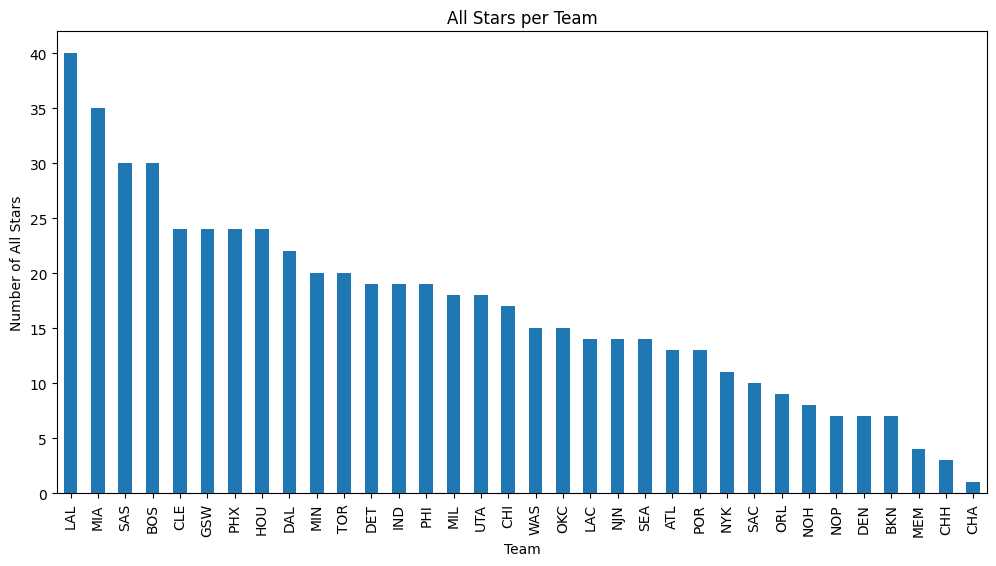

In [42]:
all_star_counts = all_seasons[all_seasons['all_star'] == 1]['team_abbreviation'].value_counts()
plt.figure(figsize=(12, 6))
all_star_counts.plot(kind='bar')
plt.title('All Stars per Team')
plt.xlabel('Team')
plt.ylabel('Number of All Stars')
plt.show()

## Treinando modelos com GridSearch

In [43]:
# Importando bibliotecas necessárias
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import log_loss

In [44]:
def log_all_experiments(exp_id, algorithm, grid_search, test_metrics):
    global experiment_table

    # Extract grid search results
    grid_results = pd.DataFrame(grid_search.cv_results_)
    
    # Expand hyperparameters into separate columns
    param_keys = list(grid_results['params'][0].keys())  # Get all hyperparameter names
    expanded_results = grid_results['params'].apply(pd.Series)
    grid_results = pd.concat([grid_results, expanded_results], axis=1)
    
    # Add details for each parameter set
    for i, row in grid_results.iterrows():
        mean_recall = row['mean_test_score']  # Assuming 'recall' is the scoring metric
        rank = row['rank_test_score']
        
        # Prepare a row for the experiment table
        row_data = {
            "Experiment ID": exp_id,
            "Algorithm": algorithm,
            "Mean Validation Recall": mean_recall,
            "Rank of hyperparameter set": rank
        }
        
        # Add hyperparameters to the row
        for param_key in param_keys:
            row_data[param_key] = row[param_key]
            
        # Add test metrics if this is the best model (rank 1)
        if rank == 1:
            for metric_name, metric_value in test_metrics.items():
                row_data[metric_name] = metric_value
        
        # Append to the experiment table
        experiment_table = pd.concat([
            experiment_table,
            pd.DataFrame([row_data])
        ], ignore_index=True)


In [45]:
# Definindo as features e o target (assumindo que 'all_star' é o alvo)
X = data.drop(columns=['all_star'])  # Features
y = data['all_star']  # Target

# Dividindo os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Support Vector Machine

In [46]:
# Definindo os parâmetros para o GridSearchCV para SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# pre processamento para o treinamento do SVM (normalização)

# normalizando os dados. criar novo dataframe para não perder as colunas originais e poder usar o original para outros modelos
min_max_scaler = MinMaxScaler()
X_train_normalized_min_max = min_max_scaler.fit_transform(X_train)
X_test_normalized_min_max = min_max_scaler.transform(X_test)

standard_scaler = StandardScaler()
X_train_normalized_standard = standard_scaler.fit_transform(X_train)
X_test_normalized_standard = standard_scaler.transform(X_test)

In [47]:
# Criando o modelo SVM e ajustando os parâmetros com GridSearchCV
svm_min_max = SVC(class_weight='balanced', random_state=42)  # Usamos 'balanced' para lidar com o desequilíbrio de classes
svm_min_max_grid_search = GridSearchCV(svm_min_max, svm_param_grid, cv=5, scoring='recall', n_jobs=10)  # Usamos Recall como métrica de validação

svm_min_max_grid_search.fit(X_train_normalized_min_max, y_train)

# Pegando o melhor modelo SVM
best_svm_model_min_max = svm_min_max_grid_search.best_estimator_

# Exibindo o melhor modelo e a melhor pontuação de recall
print("Melhor modelo SVM (MinMaxScaler):", best_svm_model_min_max)
print("Melhor pontuação de recall:", svm_min_max_grid_search.best_score_)

Melhor modelo SVM (MinMaxScaler): SVC(C=10, class_weight='balanced', gamma='auto', random_state=42)
Melhor pontuação de recall: 0.9350864890135577


In [48]:
# Fazendo previsões no conjunto de teste
y_pred_svm_min_max = best_svm_model_min_max.predict(X_test_normalized_min_max)

In [49]:
# Calculando as métricas de avaliação
accuracy_svm_min_max = accuracy_score(y_test, y_pred_svm_min_max)
precision_svm_min_max = precision_score(y_test, y_pred_svm_min_max, average='weighted')  # average='weighted' para lidar com classes desbalanceadas
recall_svm_min_max = recall_score(y_test, y_pred_svm_min_max, average='weighted')
f1_svm_min_max = f1_score(y_test, y_pred_svm_min_max, average='weighted')

# Exibindo as métricas
print(f"Accuracy: {accuracy_svm_min_max:.4f}")
print(f"Precision: {precision_svm_min_max:.4f}")
print(f"Recall: {recall_svm_min_max:.4f}")
print(f"F1 Score: {f1_svm_min_max:.4f}")

Accuracy: 0.8906
Precision: 0.9678
Recall: 0.8906
F1 Score: 0.9182


In [50]:
# Relatório completo de classificação
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm_min_max))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      2464
           1       0.27      0.95      0.42       105

    accuracy                           0.89      2569
   macro avg       0.63      0.92      0.68      2569
weighted avg       0.97      0.89      0.92      2569



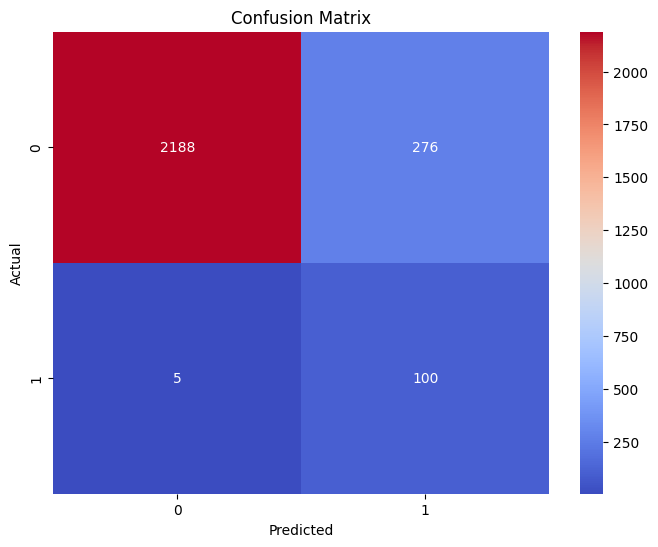

In [51]:
# Matriz de confusão
conf_matrix_svm_min_max = confusion_matrix(y_test, y_pred_svm_min_max)

# Plotando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm_min_max, annot=True, fmt="d", cmap="coolwarm", xticklabels=best_svm_model_min_max.classes_, yticklabels=best_svm_model_min_max.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [52]:
# Log-loss (disponível apenas para modelos que fornecem probabilidades)
y_proba_svm_min_max = best_svm_model_min_max.decision_function(X_test_normalized_min_max)
logloss_svm_min_max = log_loss(y_test, y_proba_svm_min_max)
print(f"Log-Loss: {logloss_svm_min_max:.4f}")

Log-Loss: 1.9289


In [53]:
# Calculando a Acurácia Balanceada
balanced_acc_svm_min_max = balanced_accuracy_score(y_test, y_pred_svm_min_max)
print(f"Balanced Accuracy: {balanced_acc_svm_min_max:.4f}")

Balanced Accuracy: 0.9202


AUC-ROC: 0.9682


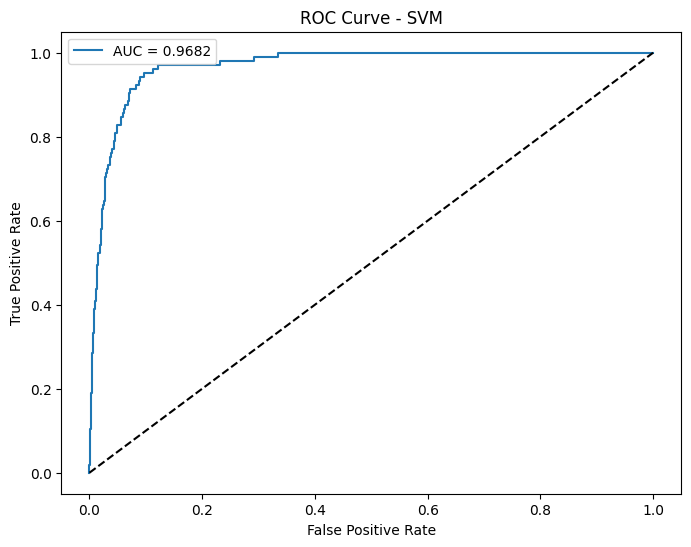

In [54]:
# Verifica se o problema é binário
if len(best_svm_model_min_max.classes_) == 2:
    y_proba_svm_min_max = best_svm_model_min_max.decision_function(X_test_normalized_min_max)
    auc_svm_min_max = roc_auc_score(y_test, y_proba_svm_min_max)
    print(f"AUC-ROC: {auc_svm_min_max:.4f}")
    
    # Plot da curva ROC
    fpr_svm_min_max, tpr_svm_min_max, _ = roc_curve(y_test, y_proba_svm_min_max)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_svm_min_max, tpr_svm_min_max, label=f"AUC = {auc_svm_min_max:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - SVM")
    plt.legend(loc="best")
    plt.show()

In [55]:
# treinando o modelo com os dados normalizados pelo StandardScaler
svm_standard = SVC(class_weight='balanced', random_state=42)  # Usamos 'balanced' para lidar com o desequilíbrio de classes
svm_standard_grid_search = GridSearchCV(svm_standard, svm_param_grid, cv=5, scoring='recall', n_jobs=10)  # Usamos Recall como métrica de validação

svm_standard_grid_search.fit(X_train_normalized_standard, y_train)

best_svm_model_standard = svm_standard_grid_search.best_estimator_

print("Melhor modelo SVM (StandardScaler):", best_svm_model_standard)
print("Melhor pontuação de recall:", svm_standard_grid_search.best_score_)

Melhor modelo SVM (StandardScaler): SVC(C=0.1, class_weight='balanced', random_state=42)
Melhor pontuação de recall: 0.9350864890135577


In [56]:
# Fazendo previsões no conjunto de teste
y_pred_svm_standard = best_svm_model_standard.predict(X_test_normalized_standard)

In [57]:
# Calculando as métricas de avaliação
accuracy_svm_standard = accuracy_score(y_test, y_pred_svm_standard)
precision_svm_standard = precision_score(y_test, y_pred_svm_standard, average='weighted')  # average='weighted' para lidar com classes desbalanceadas
recall_svm_standard = recall_score(y_test, y_pred_svm_standard, average='weighted')
f1_svm_standard = f1_score(y_test, y_pred_svm_standard, average='weighted')

# Exibindo as métricas
print(f"Accuracy: {accuracy_svm_standard:.4f}")
print(f"Precision: {precision_svm_standard:.4f}")
print(f"Recall: {recall_svm_standard:.4f}")
print(f"F1 Score: {f1_svm_standard:.4f}")

Accuracy: 0.8887
Precision: 0.9677
Recall: 0.8887
F1 Score: 0.9170


In [58]:
# Relatório completo de classificação
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm_standard))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      2464
           1       0.26      0.95      0.41       105

    accuracy                           0.89      2569
   macro avg       0.63      0.92      0.68      2569
weighted avg       0.97      0.89      0.92      2569



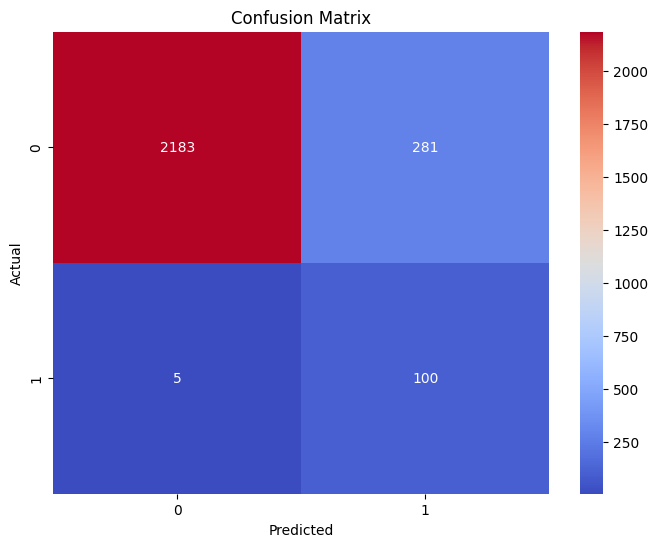

In [59]:
# Matriz de confusão
conf_matrix_svm_standard = confusion_matrix(y_test, y_pred_svm_standard)

# Plotando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm_standard, annot=True, fmt="d", cmap="coolwarm", xticklabels=best_svm_model_standard.classes_, yticklabels=best_svm_model_standard.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [60]:
# Log-loss (disponível apenas para modelos que fornecem probabilidades)
y_proba_svm_standard = best_svm_model_standard.decision_function(X_test_normalized_standard)
logloss_svm_standard = log_loss(y_test, y_proba_svm_standard)
print(f"Log-Loss: {logloss_svm_standard:.4f}")

Log-Loss: 1.4760


Balanced Accuracy: 0.9192
AUC-ROC: 0.9627


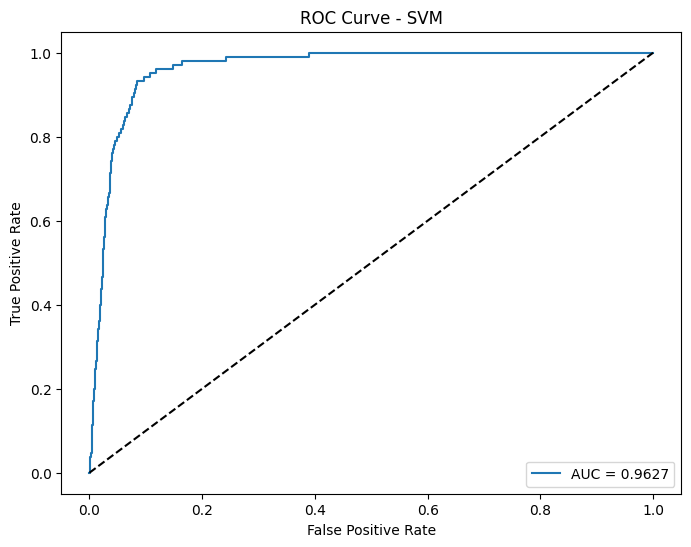

In [61]:
# Calculando a Acurácia Balanceada
balanced_acc_svm_standard = balanced_accuracy_score(y_test, y_pred_svm_standard)
print(f"Balanced Accuracy: {balanced_acc_svm_standard:.4f}")
# Verifica se o problema é binário
if len(best_svm_model_standard.classes_) == 2:
    y_proba_svm_standard = best_svm_model_standard.decision_function(X_test_normalized_standard)
    auc_svm_standard = roc_auc_score(y_test, y_proba_svm_standard)
    print(f"AUC-ROC: {auc_svm_standard:.4f}")
    # Plot da curva ROC
    fpr_svm_standard, tpr_svm_standard, _ = roc_curve(y_test, y_proba_svm_standard)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_svm_standard, tpr_svm_standard, label=f"AUC = {auc_svm_standard:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - SVM")
    plt.legend(loc="best")
    plt.show()

### Random Forest

In [62]:
# Definindo os parâmetros para o GridSearchCV para Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Criando o modelo Random Forest e ajustando os parâmetros com GridSearchCV
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=10)  # Usamos 'balanced' para lidar com o desequilíbrio de classes
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5, scoring='recall')  # Usamos Recall como métrica de validação
rf_grid_search.fit(X_train, y_train)

# Pegando o melhor modelo Random Forest
best_rf_model = rf_grid_search.best_estimator_

# Exibindo o melhor modelo e a melhor pontuação de Recall
print("Melhor modelo Random Forest:", best_rf_model)
print("Melhor pontuação de Recall:", rf_grid_search.best_score_)

Melhor modelo Random Forest: RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=500, n_jobs=10, random_state=42)
Melhor pontuação de Recall: 0.7558672276764844


In [63]:
# Fazendo previsões no conjunto de teste
y_pred_rf = best_rf_model.predict(X_test)

In [64]:
# Calculando as métricas de avaliação
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')  # average='weighted' para lidar com classes desbalanceadas
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# Exibindo as métricas
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")

Accuracy: 0.9447
Precision: 0.9674
Recall: 0.9447
F1 Score: 0.9531


In [65]:
# Relatório completo de classificação
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2464
           1       0.41      0.80      0.54       105

    accuracy                           0.94      2569
   macro avg       0.70      0.88      0.76      2569
weighted avg       0.97      0.94      0.95      2569



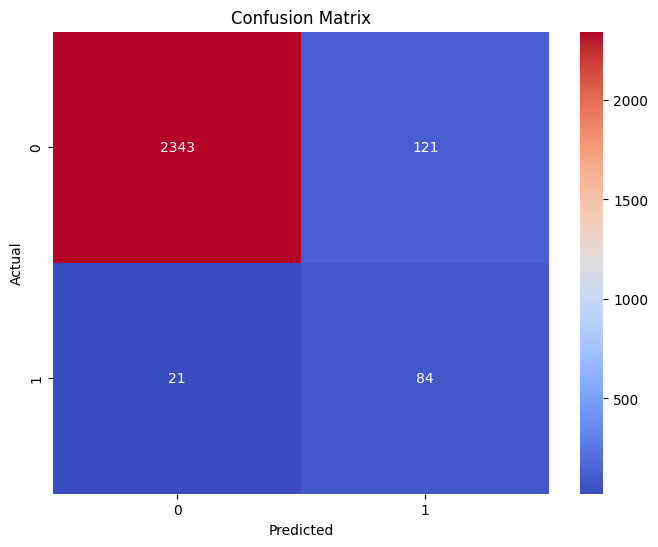

In [66]:
# Matriz de confusão
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Plotando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="coolwarm", xticklabels=best_rf_model.classes_, yticklabels=best_rf_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [67]:
# Log-loss (disponível apenas para modelos que fornecem probabilidades)
y_proba_rf = best_rf_model.predict_proba(X_test)
logloss_rf = log_loss(y_test, y_proba_rf)
print(f"Log-Loss: {logloss_rf:.4f}")

Log-Loss: 0.1268


In [68]:
# Calculando a Acurácia Balanceada
balanced_acc_rf = balanced_accuracy_score(y_test, y_pred_rf)
print(f"Balanced Accuracy: {balanced_acc_rf:.4f}")

Balanced Accuracy: 0.8754


AUC-ROC: 0.9670


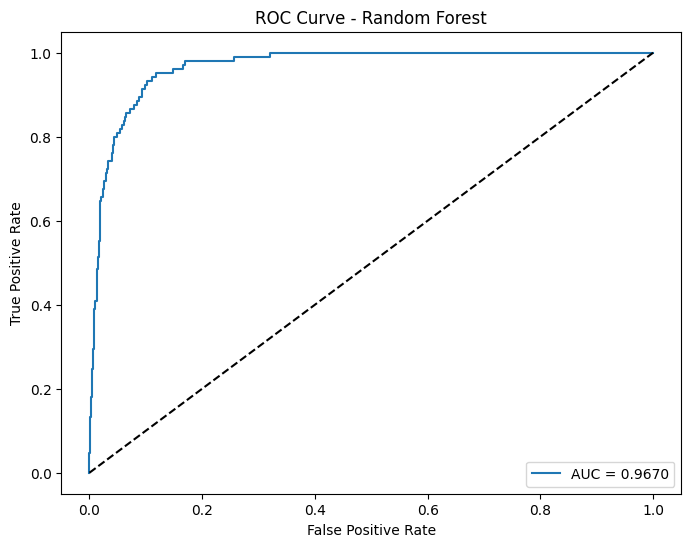

In [69]:
# Verifica se o problema é binário
if len(best_rf_model.classes_) == 2:
    y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]
    auc_rf = roc_auc_score(y_test, y_proba_rf)
    print(f"AUC-ROC: {auc_rf:.4f}")
    
    # Plot da curva ROC
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_rf, tpr_rf, label=f"AUC = {auc_rf:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Random Forest")
    plt.legend(loc="best")
    plt.show()

### XGBoost

In [70]:
# Parâmetros para o GridSearchCV para XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'scale_pos_weight': [len(y_train[y_train == 0]) / len(y_train[y_train == 1])]  # Ajuste de peso da classe positiva
}

# Criando o modelo XGBoost e ajustando os parâmetros com GridSearchCV usando recall como métrica
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=10, tree_method=XGBOOST_TREE_METHOD)
xgb_grid_search = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring='recall')
xgb_grid_search.fit(X_train, y_train)

# Melhor modelo XGBoost baseado no recall
best_xgb_model = xgb_grid_search.best_estimator_

# Exibindo o melhor modelo e a melhor pontuação de recall
print("Melhor modelo XGBoost:", best_xgb_model)
print("Melhor pontuação de recall:", xgb_grid_search.best_score_)

/home/luizfneves/.local/share/virtualenvs/eng4040-33a-grupo-c-prHDLwo0/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:38:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/luizfneves/.local/share/virtualenvs/eng4040-33a-grupo-c-prHDLwo0/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:38:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/luizfneves/.local/share/virtualenvs/eng4040-33a-grupo-c-prHDLwo0/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:38:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/luizfneves/.local/share/virtualenvs/eng4040-33a-grupo-c-prHDLwo0/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:38:09] WARNING: /workspace/src/learner.cc:740:

Melhor modelo XGBoost: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=10, num_parallel_tree=None, random_state=42, ...)
Melhor pontuação de recall: 0.9308555399719495


/home/luizfneves/.local/share/virtualenvs/eng4040-33a-grupo-c-prHDLwo0/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:42:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [71]:
# Fazendo previsões no conjunto de teste
y_pred_xgb = best_xgb_model.predict(X_test)

In [72]:
# Calculando as métricas de avaliação
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')  # average='weighted' para lidar com classes desbalanceadas
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

# Exibindo as métricas
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")

Accuracy: 0.8836
Precision: 0.9663
Recall: 0.8836
F1 Score: 0.9135


In [73]:
# Relatório completo de classificação
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94      2464
           1       0.25      0.93      0.40       105

    accuracy                           0.88      2569
   macro avg       0.62      0.91      0.67      2569
weighted avg       0.97      0.88      0.91      2569



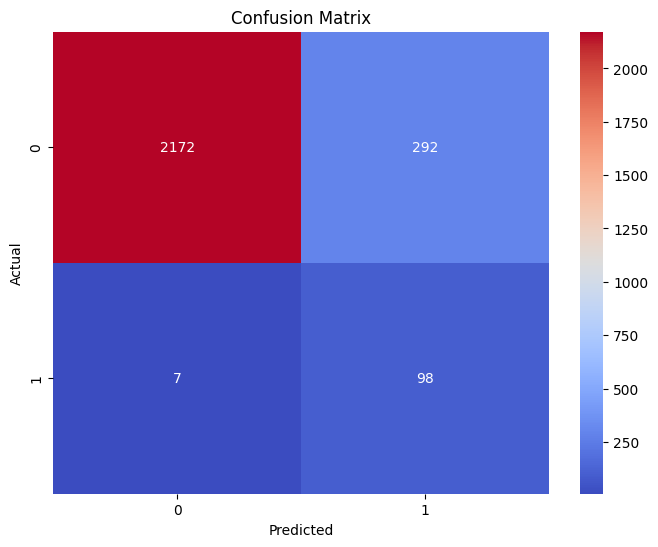

In [74]:
# Matriz de confusão
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plotando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="coolwarm", xticklabels=best_xgb_model.classes_, yticklabels=best_xgb_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [75]:
# Log-loss (disponível apenas para modelos que fornecem probabilidades)
y_proba_xgb = best_xgb_model.predict_proba(X_test)
logloss_xgb = log_loss(y_test, y_proba_xgb)
print(f"Log-Loss: {logloss_xgb:.4f}")

Log-Loss: 0.3657


In [76]:
# Calculando a Acurácia Balanceada
balanced_acc_xgb = balanced_accuracy_score(y_test, y_pred_xgb)
print(f"Balanced Accuracy: {balanced_acc_xgb:.4f}")

Balanced Accuracy: 0.9074


AUC-ROC: 0.9554


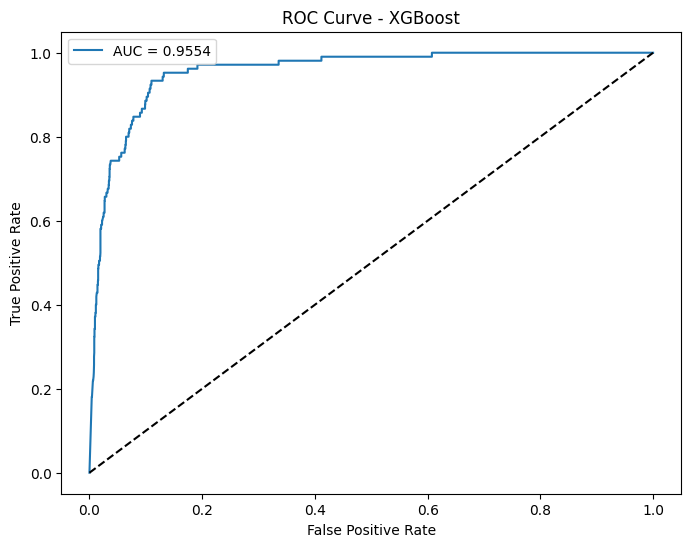

In [77]:
# Verifica se o problema é binário
if len(best_xgb_model.classes_) == 2:
    y_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]
    auc_xgb = roc_auc_score(y_test, y_proba_xgb)
    print(f"AUC-ROC: {auc_xgb:.4f}")
    
    # Plot da curva ROC
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_xgb, tpr_xgb, label=f"AUC = {auc_xgb:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - XGBoost")
    plt.legend(loc="best")
    plt.show()

### Comparações entre os modelos

In [78]:
# Suponha que essas sejam as métricas calculadas para cada modelo
model_names = ['SVM (Min-Max)', 'SVM (StandardScaler)', 'Random Forest', 'XGBoost']
accuracy_scores = [accuracy_svm_min_max, accuracy_svm_standard, accuracy_rf, accuracy_xgb]
precision_scores = [precision_svm_min_max, precision_svm_standard, precision_rf, precision_xgb]
recall_scores = [recall_svm_min_max, recall_svm_standard, recall_rf, recall_xgb]
f1_scores = [f1_svm_min_max, f1_svm_standard, f1_rf, f1_xgb]

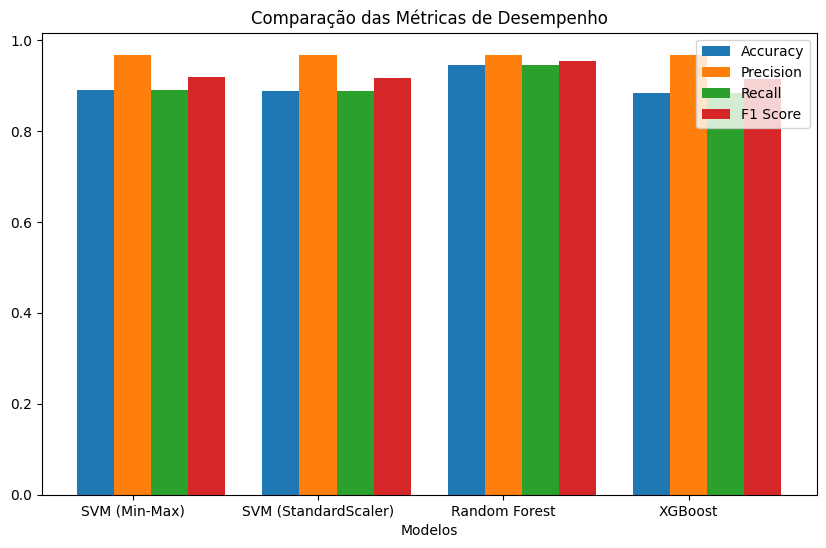

In [79]:
# Criando o gráfico de comparação de métricas
x = np.arange(len(model_names))  # Posições das barras
width = 0.2  # Largura das barras

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, accuracy_scores, width, label='Accuracy')
bars2 = ax.bar(x, precision_scores, width, label='Precision')
bars3 = ax.bar(x + width, recall_scores, width, label='Recall')
bars4 = ax.bar(x + 2 * width, f1_scores, width, label='F1 Score')

ax.set_xlabel('Modelos')
ax.set_title('Comparação das Métricas de Desempenho')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

plt.show()

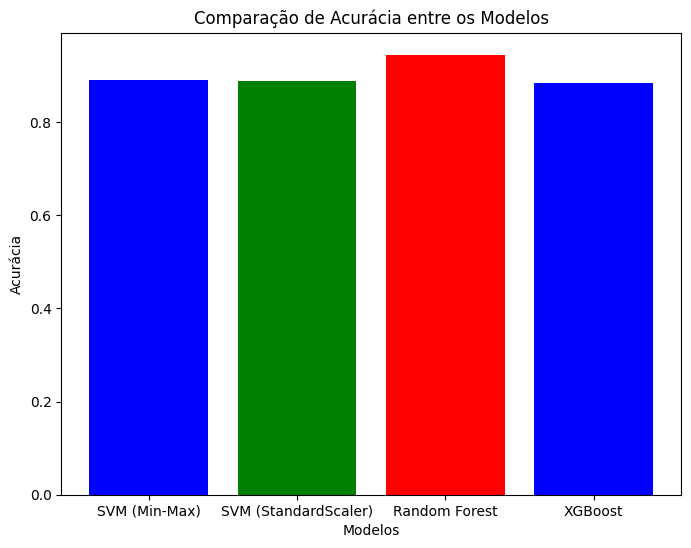

In [80]:
# Gráfico de Acurácia
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracy_scores, color=['blue', 'green', 'red'])
plt.title('Comparação de Acurácia entre os Modelos')
plt.xlabel('Modelos')
plt.ylabel('Acurácia')
plt.show()

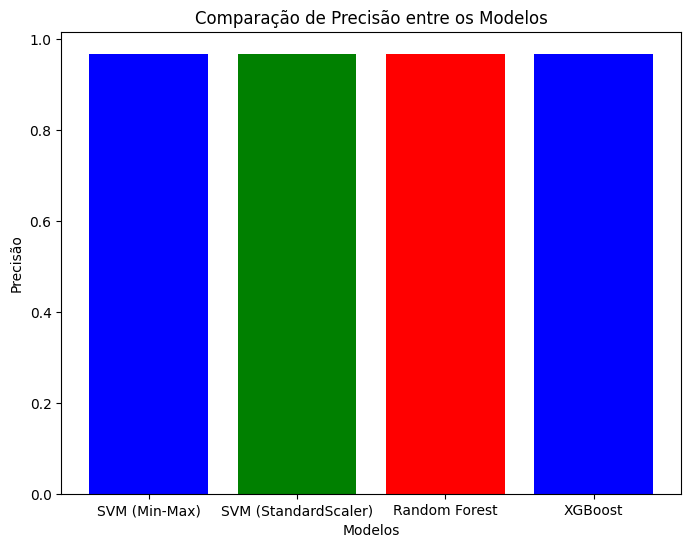

In [81]:
# Gráfico de Precisão
plt.figure(figsize=(8, 6))
plt.bar(model_names, precision_scores, color=['blue', 'green', 'red'])
plt.title('Comparação de Precisão entre os Modelos')
plt.xlabel('Modelos')
plt.ylabel('Precisão')
plt.show()

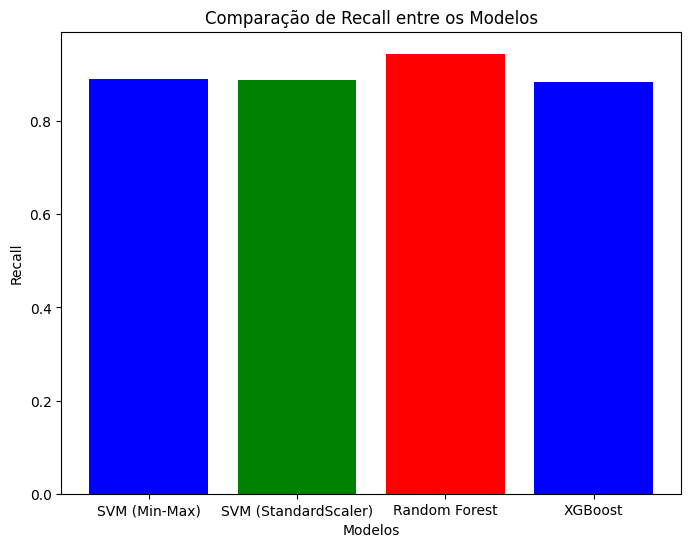

In [82]:
# Gráfico de Recall
plt.figure(figsize=(8, 6))
plt.bar(model_names, recall_scores, color=['blue', 'green', 'red'])
plt.title('Comparação de Recall entre os Modelos')
plt.xlabel('Modelos')
plt.ylabel('Recall')
plt.show()


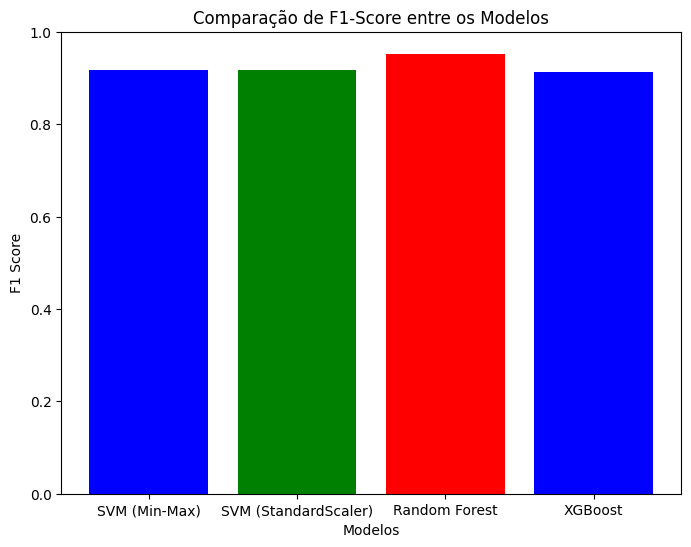

In [83]:
# Gráfico de F1 Score
plt.figure(figsize=(8, 6))
plt.bar(model_names, f1_scores, color=['blue', 'green', 'red'])
plt.title('Comparação de F1-Score entre os Modelos')
plt.xlabel('Modelos')
plt.ylabel('F1 Score')
plt.show()

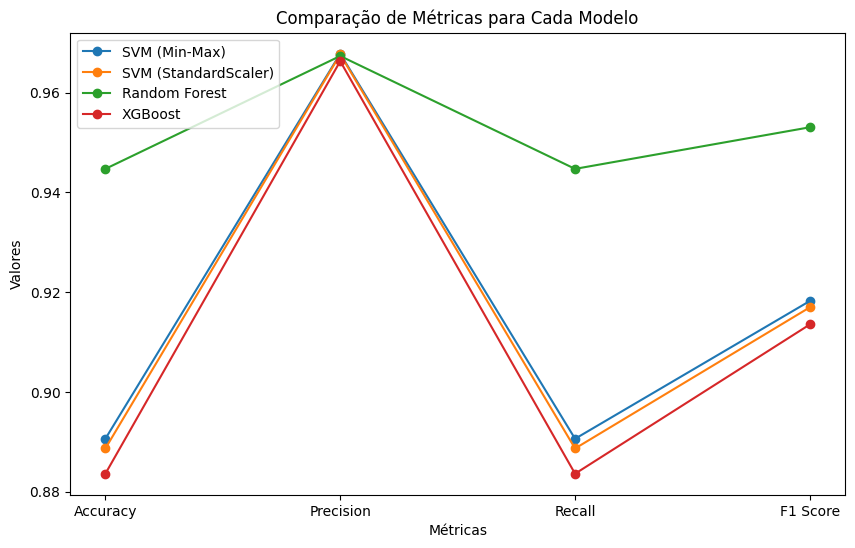

In [94]:
# Gráfico de Linha para Resumo das Métricas
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Organizar scores por modelo
svm_minmax_scores = [accuracy_svm_min_max, precision_svm_min_max, recall_svm_min_max, f1_svm_min_max]
svm_std_scores = [accuracy_svm_standard, precision_svm_standard, recall_svm_standard, f1_svm_standard] 
rf_scores = [accuracy_rf, precision_rf, recall_rf, f1_rf]
xgb_scores = [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb]

plt.figure(figsize=(10, 6))
plt.plot(metrics, svm_minmax_scores, marker='o', label='SVM (Min-Max)')
plt.plot(metrics, svm_std_scores, marker='o', label='SVM (StandardScaler)') 
plt.plot(metrics, rf_scores, marker='o', label='Random Forest')
plt.plot(metrics, xgb_scores, marker='o', label='XGBoost')

plt.title('Comparação de Métricas para Cada Modelo')
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.legend()
plt.show()

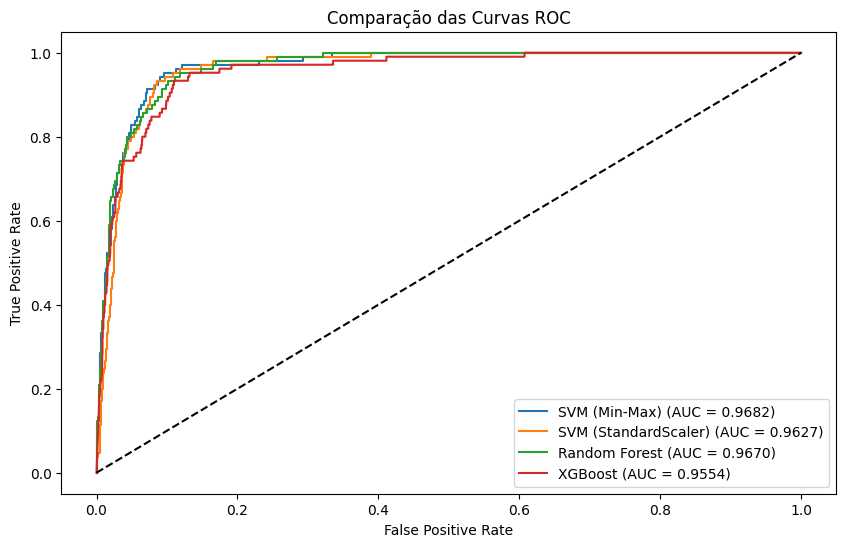

In [85]:
# Plotando as curvas ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_svm_min_max, tpr_svm_min_max, label=f'SVM (Min-Max) (AUC = {auc_svm_min_max:.4f})')
plt.plot(fpr_svm_standard, tpr_svm_standard, label=f'SVM (StandardScaler) (AUC = {auc_svm_standard:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Linha de referência
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparação das Curvas ROC")
plt.legend(loc="best")
plt.show()

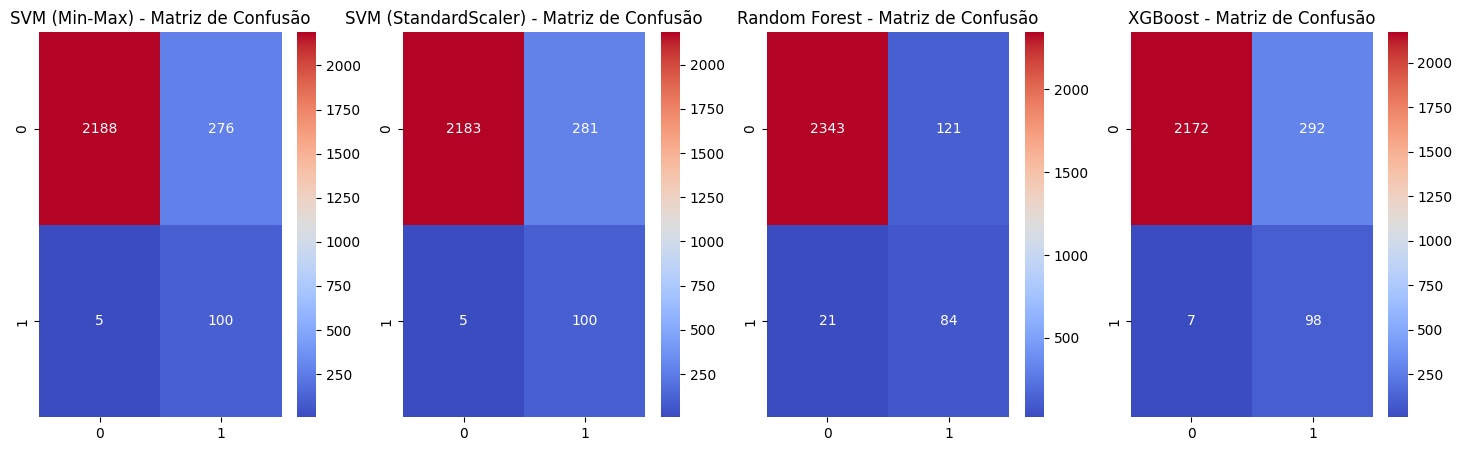

In [89]:
# Plotando a matriz de confusão para cada modelo
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# SVM
conf_matrix_svm_min_max = confusion_matrix(y_test, y_pred_svm_min_max)
sns.heatmap(conf_matrix_svm_min_max, annot=True, fmt="d", cmap="coolwarm", ax=axes[0])
axes[0].set_title("SVM (Min-Max) - Matriz de Confusão")

conf_matrix_svm_standard = confusion_matrix(y_test, y_pred_svm_standard)
sns.heatmap(conf_matrix_svm_standard, annot=True, fmt="d", cmap="coolwarm", ax=axes[1])
axes[1].set_title("SVM (StandardScaler) - Matriz de Confusão")

# Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="coolwarm", ax=axes[2])
axes[2].set_title("Random Forest - Matriz de Confusão")

# XGBoost
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="coolwarm", ax=axes[3])
axes[3].set_title("XGBoost - Matriz de Confusão")

plt.show()

In [87]:
experiment_table = pd.DataFrame(columns=[
    "Experiment ID", "Algorithm", "Mean Validation Recall", "Rank of hyperparameter set"
])

best_svm_min_max_test_metrics = {
    "accuracy": accuracy_svm_min_max,
    "precision": precision_svm_min_max,
    "recall": recall_svm_min_max,
    "f1": f1_svm_min_max,
    "balanced_accuracy": balanced_acc_svm_min_max
}

best_svm_standard_test_metrics = {
    "accuracy": accuracy_svm_standard,
    "precision": precision_svm_standard,
    "recall": recall_svm_standard,
    "f1": f1_svm_standard,
    "balanced_accuracy": balanced_acc_svm_standard
}

best_rf_test_metrics = {
    "accuracy": accuracy_rf,
    "precision": precision_rf,
    "recall": recall_rf,
    "f1": f1_rf,
    "balanced_accuracy": balanced_acc_rf
}
best_xgb_test_metrics = {
    "accuracy": accuracy_xgb,
    "precision": precision_xgb,
    "recall": recall_xgb,
    "f1": f1_xgb,
    "balanced_accuracy": balanced_acc_xgb
}
log_all_experiments(exp_id=1, algorithm="SVM (Min-Max)", grid_search=svm_min_max_grid_search, test_metrics=best_svm_min_max_test_metrics)
log_all_experiments(exp_id=2, algorithm="SVM (StandardScaler)", grid_search=svm_standard_grid_search, test_metrics=best_svm_standard_test_metrics)
log_all_experiments(exp_id=3, algorithm="Random Forest", grid_search=rf_grid_search, test_metrics=best_rf_test_metrics)
log_all_experiments(exp_id=4, algorithm="XGBoost", grid_search=xgb_grid_search, test_metrics=best_xgb_test_metrics)

experiment_table.to_csv("detailed_experiment_results.csv", index=False)

/tmp/ipykernel_7388/1188541083.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  experiment_table = pd.concat([


In [92]:
def intervalo_confianca_metricas(y_test, y_pred, n_bootstrap=1000, confidence_level=95):
    """
    Calcula os intervalos de confiança para várias métricas usando bootstrap.
    
    Parâmetros:
    - y_test: array ou lista com os valores reais das classes.
    - y_pred: array ou lista com as previsões do modelo.
    - n_bootstrap: número de iterações de bootstrap.
    - confidence_level: nível de confiança (em porcentagem, ex.: 95).
    """
    metrics = {
        'accuracy': accuracy_score,
        'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted'),
        'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted'),
        'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted')
    }
    
    results = {metric: [] for metric in metrics}

    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    for _ in range(n_bootstrap):
        indices = np.random.choice(len(y_test), len(y_test), replace=True)
        bootstrap_y_test = y_test[indices]
        bootstrap_y_pred = y_pred[indices]
        
        for metric_name, metric_func in metrics.items():
            results[metric_name].append(metric_func(bootstrap_y_test, bootstrap_y_pred))
    
    intervals = {}
    for metric_name, values in results.items():
        lower_bound = np.percentile(values, (100 - confidence_level) / 2)
        upper_bound = np.percentile(values, 100 - (100 - confidence_level) / 2)
        intervals[metric_name] = (lower_bound, upper_bound)
    
    print("Intervalos de confiança:")
    for metric_name, (lower, upper) in intervals.items():
        print(f"- {metric_name}: {lower:.4f} - {upper:.4f}")

y_pred = best_svm_model_min_max.predict(X_test_normalized_min_max)
intervalo_confianca_metricas(y_test, y_pred)

y_pred = best_svm_model_standard.predict(X_test_normalized_standard)
intervalo_confianca_metricas(y_test, y_pred)

y_pred = best_rf_model.predict(X_test)
intervalo_confianca_metricas(y_test, y_pred)

y_pred = best_xgb_model.predict(X_test)
intervalo_confianca_metricas(y_test, y_pred)

Intervalos de confiança:
- accuracy: 0.8786 - 0.9027
- precision: 0.9627 - 0.9726
- recall: 0.8786 - 0.9027
- f1: 0.9104 - 0.9265
Intervalos de confiança:
- accuracy: 0.8766 - 0.9015
- precision: 0.9629 - 0.9730
- recall: 0.8766 - 0.9015
- f1: 0.9089 - 0.9255
Intervalos de confiança:
- accuracy: 0.9358 - 0.9529
- precision: 0.9613 - 0.9732
- recall: 0.9358 - 0.9529
- f1: 0.9462 - 0.9599
Intervalos de confiança:
- accuracy: 0.8708 - 0.8953
- precision: 0.9610 - 0.9720
- recall: 0.8708 - 0.8953
- f1: 0.9048 - 0.9219
